# Exploration
Constant VPD experiment: ```/glade/campaign/univ/uwas0098/cnstVPDforPhoto_PI_SOM/tseries/TimeSeries/```

Control experiment:
```/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/COUP0000_PI_SOM/domain/proc/tseries/```

# Setup

In [2]:
import os
import numpy as np
import xarray as xr
import pickle as pkl

import cartopy
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.path as mpath

import cmocean.cm as cmo

In [3]:
## some magic to automatically reload my functions before running a new cell
%load_ext autoreload
## %reload_ext autoreload
%autoreload 1
%aimport climate_data_science_functions

import climate_data_science_functions as cds

## Figure settings

In [4]:
## Adjust dpi
mpl.rcParams['figure.dpi'] = 80

## Assign figure output format
# %config InlineBackend.figure_formats = ['pdf']
%config InlineBackend.figure_formats = ['png']

# Import data

In [5]:
## Constant VPD experiment
path_cstvpd = '/glade/campaign/univ/uwas0098/cnstVPDforPhoto_PI_SOM/tseries/TimeSeries/'

varlist_cstvpd = []
for file in os.listdir(path_cstvpd):
    varlist_cstvpd.append(file.split('.')[5])
varlist_cstvpd = sorted(varlist_cstvpd)

In [6]:
## Control VPD experiment
basepath_ctlvpd = '/glade/campaign/cgd/tss/czarakas/CoupledPPE/'
ensemble = 'coupled'
domain = 'atm'

if ensemble == 'offline':
    ensemble_path = 'offline_simulations'
    refcase_id = 'OFFL0000_PI_v02'
elif ensemble == 'coupled':
    ensemble_path = 'coupled_simulations'
    refcase_id = 'COUP0000_PI_SOM'

if domain == 'atm':
    domain_suffix = '.cam.h0.'
elif domain == 'lnd':
    domain_suffix = '.clm2.h0.'

path_ctlvpd = basepath_ctlvpd+ensemble_path+'/'+refcase_id+'/'+domain+'/proc/tseries/'

varlist_ctlvpd = []
for file in os.listdir(path_ctlvpd):
    if file.split('.')[2] == 'h0':
        varlist_ctlvpd.append(file.split('.')[4])
varlist_ctlvpd = sorted(varlist_ctlvpd)

In [7]:
## Get the variables in common between the two experiments
set_cstvpd = set(varlist_cstvpd)
set_ctlvpd = set(varlist_ctlvpd)
varlist = sorted(list(set_cstvpd.intersection(set_ctlvpd)))
print(varlist)

['CLDHGH', 'CLDLOW', 'CLDMED', 'CLDTOT', 'FLDS', 'FLNS', 'FLNSC', 'FLNT', 'FLNTC', 'FLUT', 'FSDS', 'FSDSC', 'FSNS', 'FSNSC', 'FSNT', 'FSNTC', 'ICEFRAC', 'LHFLX', 'PRECC', 'PRECL', 'PRECSC', 'PRECSL', 'Q', 'SHFLX', 'TREFHT', 'TS']


In [8]:
# Overlapping time period between control and constat VPD experiments
tslice = slice('0049-02','0083-01')

# Land mask

In [54]:
input_topo = xr.open_dataset('/glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_1.9x2.5_nc3000_Nsw084_Nrs016_Co120_Fi001_ZR_GRNL_c190405.nc')
lf = input_topo['LANDFRAC']

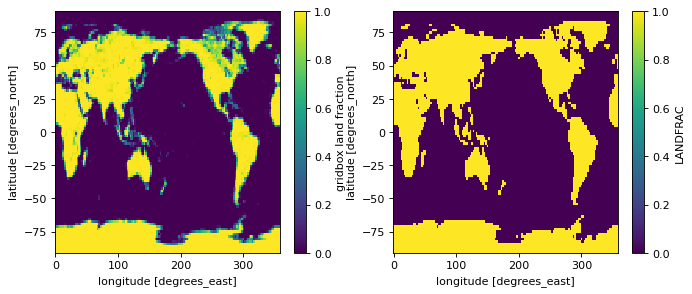

In [58]:
landthresh = 0.25
landmask = xr.where(lf>landthresh,True,False)

fig,ax = plt.subplots(1,2,figsize=(10,4))
lf.plot(ax=ax[0])
landmask.plot(ax=ax[1])

# Near-surface air temperature

In [9]:
var = 'TREFHT'
convert_temp = 273.15

tref_ctl = xr.open_dataset(path_ctlvpd+refcase_id+domain_suffix+'timeseries.'+var+'.nc')[var].sel(time=tslice) - convert_temp
tref_vpd = xr.open_dataset(path_cstvpd+'cnstVPDforPhoto_PI_SOM.cam.h0.ts.allyears.'+var+'.nc')[var].sel(time=tslice) - convert_temp

## Single month

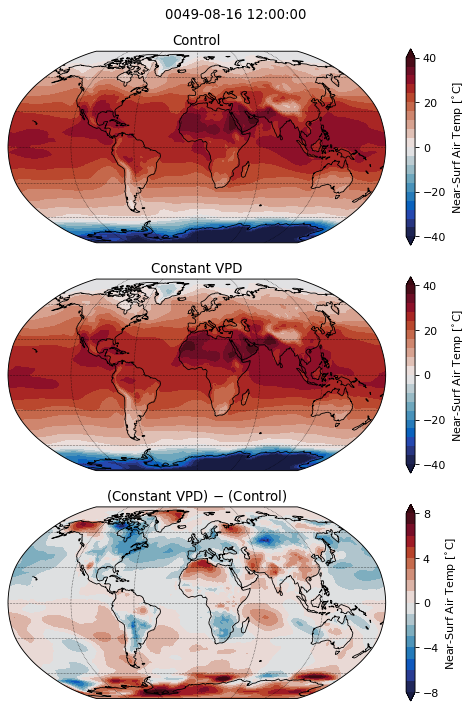

In [38]:
ixt = 6

lon = tref_ctl.lon
mapproj = ccrs.Robinson()
cmap = cmo.balance
cflevels = np.arange(-40,40.1,4)
cbticks = [-40,-20,0,20,40]
cblabel = 'Near-Surf Air Temp [$^{\circ}$C]'

fig,axes = plt.subplots(3,1,figsize=(6,9),subplot_kw={'projection':mapproj})
ax = axes.ravel()

cf_ctl = cds.cyclic_contourf(ax[0], tref_ctl.isel(time=ixt),
                             levels=cflevels, cmap=cmap, extend='both',
                             transform=ccrs.PlateCarree())
cb_ctl = fig.colorbar(cf_ctl, ax=ax[0], fraction=0.025, label=cblabel)
cb_ctl.set_ticks(cbticks)
ax[0].set_title('Control')

cf_vpd = cds.cyclic_contourf(ax[1], tref_vpd.isel(time=ixt),
                             levels=cflevels, cmap=cmap, extend='both',
                             transform=ccrs.PlateCarree())
cb_vpd = fig.colorbar(cf_vpd, ax=ax[1], fraction=0.025, label=cblabel)
cb_vpd.set_ticks(cbticks)
ax[1].set_title('Constant VPD')

cf_dif = cds.cyclic_contourf(ax[2], tref_vpd.isel(time=ixt)-tref_ctl.isel(time=ixt),
                             levels=np.arange(-8,8.1,1), cmap=cmap, extend='both',
                             transform=ccrs.PlateCarree())
cb_dif = fig.colorbar(cf_dif, ax=ax[2], fraction=0.025, label=cblabel)
cb_dif.set_ticks([-8,-4,0,4,8])
ax[2].set_title('(Constant VPD) $-$ (Control)')

for a in ax:
    a.coastlines(lw=0.75)
    cds.add_cartopy_gridlines(a, mapproj)

fig.suptitle(tref_ctl.time.isel(time=ixt).values)
fig.tight_layout()

## Time average

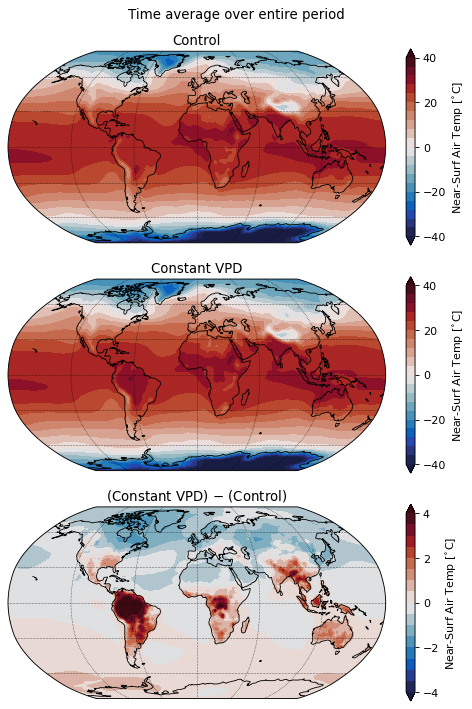

In [136]:
lon = tref_ctl.lon
mapproj = ccrs.Robinson()
cmap = cmo.balance
cflevels = np.arange(-40,40.1,4)
cbticks = [-40,-20,0,20,40]
cblabel = 'Near-Surf Air Temp [$^{\circ}$C]'

fig,axes = plt.subplots(3,1,figsize=(6,9),subplot_kw={'projection':mapproj})
ax = axes.ravel()

cf_ctl = cds.cyclic_contourf(ax[0], tref_ctl.mean(dim='time'),
                             levels=cflevels, cmap=cmap, extend='both',
                             transform=ccrs.PlateCarree())
cb_ctl = fig.colorbar(cf_ctl, ax=ax[0], fraction=0.025, label=cblabel)
cb_ctl.set_ticks(cbticks)
ax[0].set_title('Control')

cf_vpd = cds.cyclic_contourf(ax[1], tref_vpd.mean(dim='time'),
                             levels=cflevels, cmap=cmap, extend='both',
                             transform=ccrs.PlateCarree())
cb_vpd = fig.colorbar(cf_vpd, ax=ax[1], fraction=0.025, label=cblabel)
cb_vpd.set_ticks(cbticks)
ax[1].set_title('Constant VPD')

cf_dif = cds.cyclic_contourf(ax[2], tref_vpd.mean(dim='time')-tref_ctl.mean(dim='time'),
                             levels=np.arange(-4,4.1,0.5), cmap=cmap, extend='both',
                             transform=ccrs.PlateCarree())
cb_dif = fig.colorbar(cf_dif, ax=ax[2], fraction=0.025, label=cblabel)
cb_dif.set_ticks([-4,-2,0,2,4])
ax[2].set_title('(Constant VPD) $-$ (Control)')

for a in ax:
    a.coastlines(lw=0.75)
    cds.add_cartopy_gridlines(a, mapproj)

fig.suptitle('Time average over entire period')
fig.tight_layout()

## Climatology maps

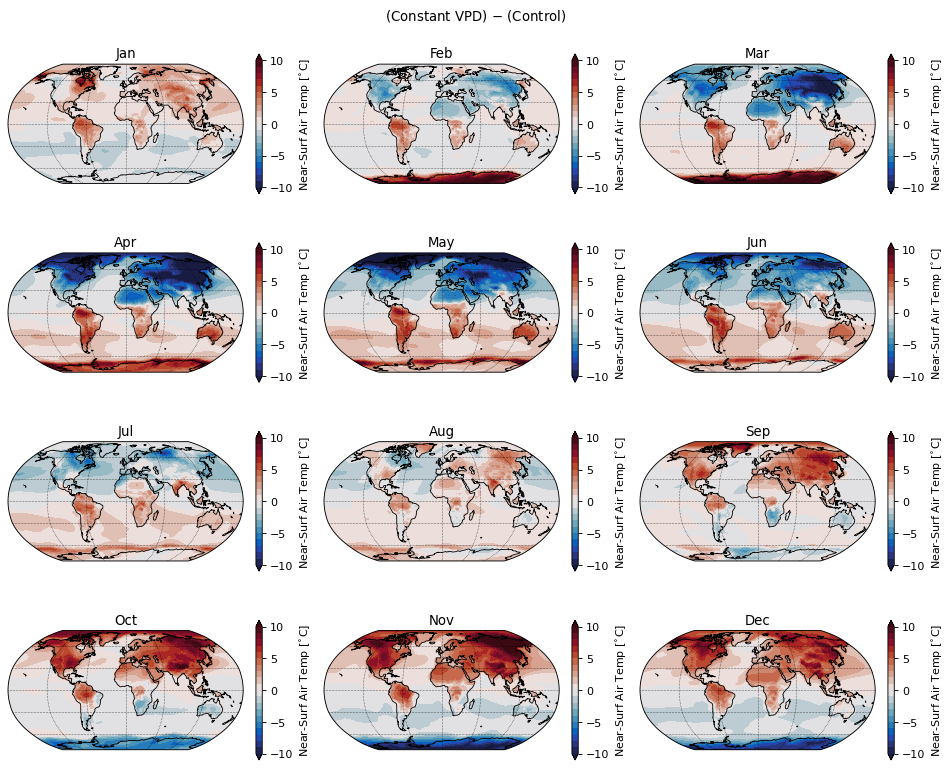

In [36]:
## Analysis
tref_ctl_clim = tref_ctl.groupby('time.month').mean(dim='time')
tref_vpd_clim = tref_vpd.groupby('time.month').mean(dim='time')

## Visualization
lon = tref_ctl.lon
mapproj = ccrs.Robinson()
cmap = cmo.balance
cflevels = np.arange(-10,10.1,1)
cbticks = [-10,-5,0,5,10]
cblabel = 'Near-Surf Air Temp [$^{\circ}$C]'
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig,axes = plt.subplots(4,3,figsize=(12,10),subplot_kw={'projection':mapproj})
ax = axes.ravel()

for i,a in enumerate(ax):
    cf_dif = cds.cyclic_contourf(a, tref_vpd_clim.isel(month=i)-tref_ctl_clim.isel(month=i),
                                 levels=cflevels, cmap=cmap, extend='both',
                                 transform=ccrs.PlateCarree())
    cb_dif = fig.colorbar(cf_dif, ax=a, fraction=0.025, label=cblabel)
    cb_dif.set_ticks(cbticks)
    a.set_title(months[i])
    a.coastlines(lw=0.75)
    cds.add_cartopy_gridlines(a, mapproj)

fig.suptitle('(Constant VPD) $-$ (Control)')
fig.tight_layout()

## Global areal average

In [103]:
# Compute the global mean using cosine(lat) weighting
lat = tref_ctl.lat
coslat_weights = np.cos(lat * np.pi / 180)
tref_ctl_globmean = (tref_ctl.mean(dim='lon') * coslat_weights).sum(dim='lat') / coslat_weights.sum()
tref_vpd_globmean = (tref_vpd.mean(dim='lon') * coslat_weights).sum(dim='lat') / coslat_weights.sum()

# Compute climatology
tref_ctl_globclim = tref_ctl_globmean.groupby('time.month').mean()
tref_vpd_globclim = tref_vpd_globmean.groupby('time.month').mean()

# Compute anomalies from climatology
tref_ctl_globanom = tref_ctl_globmean.groupby('time.month') - tref_ctl_globclim
tref_vpd_globanom = tref_vpd_globmean.groupby('time.month') - tref_vpd_globclim

### Climatology timeseries

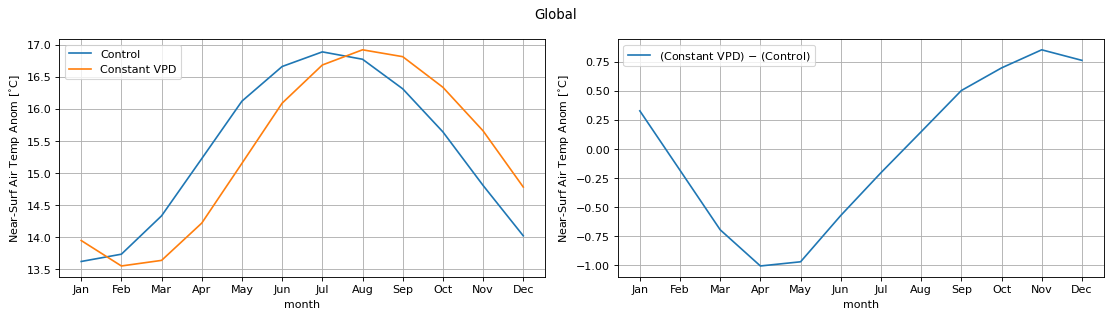

In [193]:
# Visualization
fig,ax = plt.subplots(1,2,figsize=(14,4))

tref_ctl_globclim.plot(ax=ax[0], label='Control')
tref_vpd_globclim.plot(ax=ax[0], label='Constant VPD')

(tref_vpd_globclim-tref_ctl_globclim).plot(ax=ax[1], label='(Constant VPD) $-$ (Control)')

for a in ax:
    a.set_xticks(np.arange(1,13))
    a.set_xticklabels(months)
    a.set_ylabel('Near-Surf Air Temp Anom [$^{\circ}$C]')
    a.legend()
    a.grid()
    
fig.suptitle('Global')
fig.tight_layout()

### Full timeseries of anomalies (deviation from climatology)

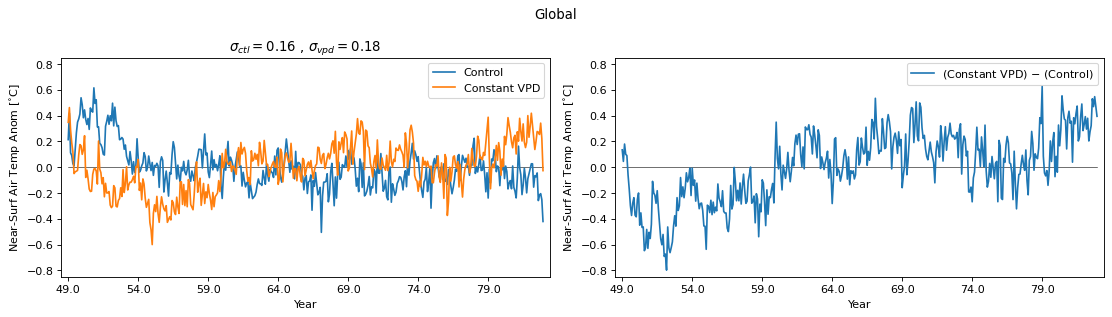

In [194]:
# Visualization
time = np.arange(49*12,83*12)

fig,ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(time, tref_ctl_globanom.values, label='Control')
ax[0].plot(time, tref_vpd_globanom.values, label='Constant VPD')
ax[0].legend()
ax[0].set_title('$\sigma_{ctl}=$'+str(tref_ctl_globanom.std().values.round(2))+' , '+
                '$\sigma_{vpd}=$'+str(tref_vpd_globanom.std().values.round(2)))

ax[1].plot(time, tref_vpd_globanom.values-tref_ctl_globanom.values, label='(Constant VPD) $-$ (Control)')
ax[1].legend()

for a in ax:
    a.plot([time[0],time[-1]], [0,0], linewidth=0.5, color='k', zorder=0)
    a.set_ylim(-0.85,0.85)
    a.set_xlim(time[0]-6, time[-1]+6)
    a.set_xticks(time[::12*5])
    a.set_xticklabels(time[::12*5]/12)
    a.set_xlabel('Year')
    a.set_ylabel('Near-Surf Air Temp Anom [$^{\circ}$C]')
    
fig.suptitle('Global')
fig.tight_layout()

## Land areal average

In [119]:
# Compute the global mean using cosine(lat) weighting
lat = tref_ctl.lat
coslat_weights = np.cos(lat * np.pi / 180)
tref_ctl_landmean = (tref_ctl.where(landmask).mean(dim='lon') * coslat_weights).sum(dim='lat') / coslat_weights.sum()
tref_vpd_landmean = (tref_vpd.where(landmask).mean(dim='lon') * coslat_weights).sum(dim='lat') / coslat_weights.sum()

# Compute climatology
tref_ctl_landclim = tref_ctl_landmean.groupby('time.month').mean()
tref_vpd_landclim = tref_vpd_landmean.groupby('time.month').mean()

# Compute anomalies from climatology
tref_ctl_landanom = tref_ctl_landmean.groupby('time.month') - tref_ctl_landclim
tref_vpd_landanom = tref_vpd_landmean.groupby('time.month') - tref_vpd_landclim

### Climatology timeseries

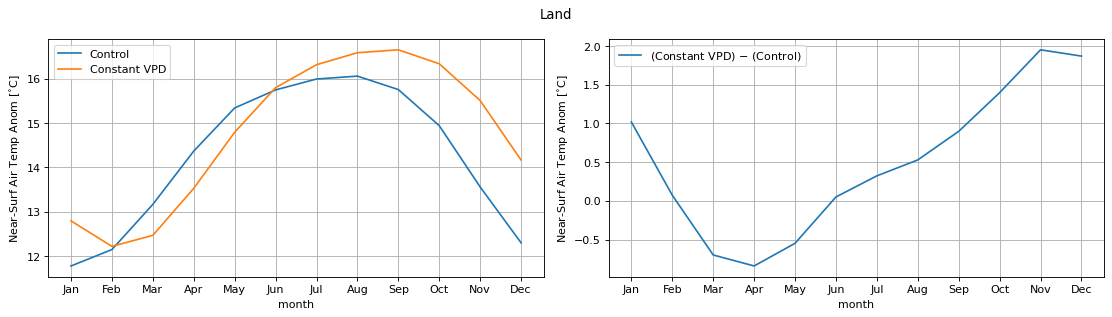

In [192]:
# Visualization
fig,ax = plt.subplots(1,2,figsize=(14,4))

tref_ctl_landclim.plot(ax=ax[0], label='Control')
tref_vpd_landclim.plot(ax=ax[0], label='Constant VPD')

(tref_vpd_landclim-tref_ctl_landclim).plot(ax=ax[1], label='(Constant VPD) $-$ (Control)')

for a in ax:
    a.set_xticks(np.arange(1,13))
    a.set_xticklabels(months)
    a.set_ylabel('Near-Surf Air Temp Anom [$^{\circ}$C]')
    a.legend()
    a.grid()
    
fig.suptitle('Land')
fig.tight_layout()

### Full timeseries of anomalies (deviation from climatology)

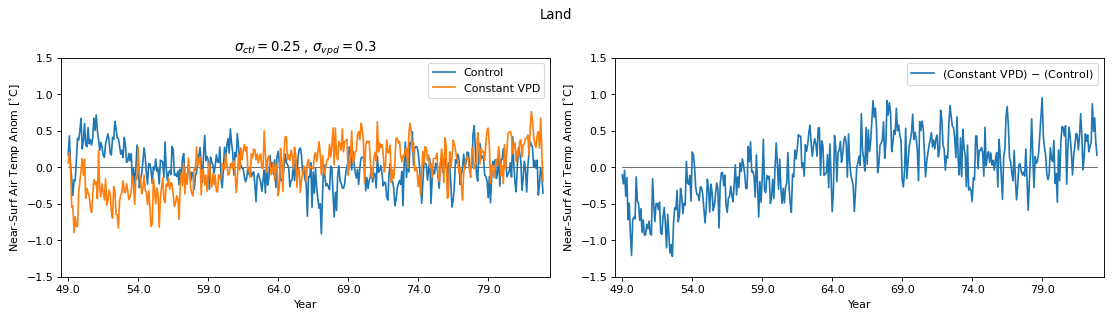

In [191]:
# Visualization
time = np.arange(49*12,83*12)

fig,ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(time, tref_ctl_landanom.values, label='Control')
ax[0].plot(time, tref_vpd_landanom.values, label='Constant VPD')
ax[0].legend()
ax[0].set_title('$\sigma_{ctl}=$'+str(tref_ctl_landanom.std().values.round(2))+' , '+
                '$\sigma_{vpd}=$'+str(tref_vpd_landanom.std().values.round(2)))

ax[1].plot(time, tref_vpd_landanom.values-tref_ctl_landanom.values, label='(Constant VPD) $-$ (Control)')
ax[1].legend()

for a in ax:
    a.plot([time[0],time[-1]], [0,0], linewidth=0.5, color='k', zorder=0)
    a.set_ylim(-1.5,1.5)
    a.set_xlim(time[0]-6, time[-1]+6)
    a.set_xticks(time[::12*5])
    a.set_xticklabels(time[::12*5]/12)
    a.set_xlabel('Year')
    a.set_ylabel('Near-Surf Air Temp Anom [$^{\circ}$C]')
    
fig.suptitle('Land')
fig.tight_layout()

# Precipitation

In [148]:
convfactor = 86400000

# Convective precipitation rate [m/s]->[mm/day]
var = 'PRECC'
precc_ctl = xr.open_dataset(path_ctlvpd+refcase_id+domain_suffix+'timeseries.'+var+'.nc')[var].sel(time=tslice) * convfactor
precc_vpd = xr.open_dataset(path_cstvpd+'cnstVPDforPhoto_PI_SOM.cam.h0.ts.allyears.'+var+'.nc')[var].sel(time=tslice) * convfactor

# Large-scale (stable) precipitation rate [m/s]->[mm/day]
var = 'PRECL'
precl_ctl = xr.open_dataset(path_ctlvpd+refcase_id+domain_suffix+'timeseries.'+var+'.nc')[var].sel(time=tslice) * convfactor
precl_vpd = xr.open_dataset(path_cstvpd+'cnstVPDforPhoto_PI_SOM.cam.h0.ts.allyears.'+var+'.nc')[var].sel(time=tslice) * convfactor

# Total precipitation [mm/day]
prec_ctl = precc_ctl + precl_ctl
prec_vpd = precc_vpd + precl_vpd

## Time average

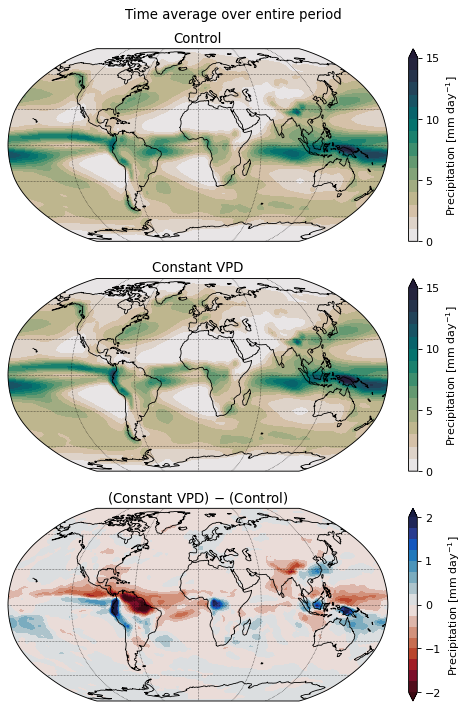

In [157]:
lon = tref_ctl.lon
mapproj = ccrs.Robinson()
cmap = cmo.rain
cflevels = np.arange(0,15.1,1)
cbticks = [0,5,10,15]
cblabel = 'Precipitation [mm day$^{-1}$]'

fig,axes = plt.subplots(3,1,figsize=(6,9),subplot_kw={'projection':mapproj})
ax = axes.ravel()

cf_ctl = cds.cyclic_contourf(ax[0], prec_ctl.mean(dim='time'),
                             levels=cflevels, cmap=cmap, extend='max',
                             transform=ccrs.PlateCarree())
cb_ctl = fig.colorbar(cf_ctl, ax=ax[0], fraction=0.025, label=cblabel)
cb_ctl.set_ticks(cbticks)
ax[0].set_title('Control')

cf_vpd = cds.cyclic_contourf(ax[1], prec_vpd.mean(dim='time'),
                             levels=cflevels, cmap=cmap, extend='max',
                             transform=ccrs.PlateCarree())
cb_vpd = fig.colorbar(cf_vpd, ax=ax[1], fraction=0.025, label=cblabel)
cb_vpd.set_ticks(cbticks)
ax[1].set_title('Constant VPD')

cf_dif = cds.cyclic_contourf(ax[2], prec_vpd.mean(dim='time')-prec_ctl.mean(dim='time'),
                             levels=np.arange(-2,2.1,0.25), cmap=cmo.balance_r, extend='both',
                             transform=ccrs.PlateCarree())
cb_dif = fig.colorbar(cf_dif, ax=ax[2], fraction=0.025, label=cblabel)
cb_dif.set_ticks([-2,-1,0,1,2])
ax[2].set_title('(Constant VPD) $-$ (Control)')

for a in ax:
    a.coastlines(lw=0.75)
    cds.add_cartopy_gridlines(a, mapproj)

fig.suptitle('Time average over entire period')
fig.tight_layout()

## Climatology maps

### Control only

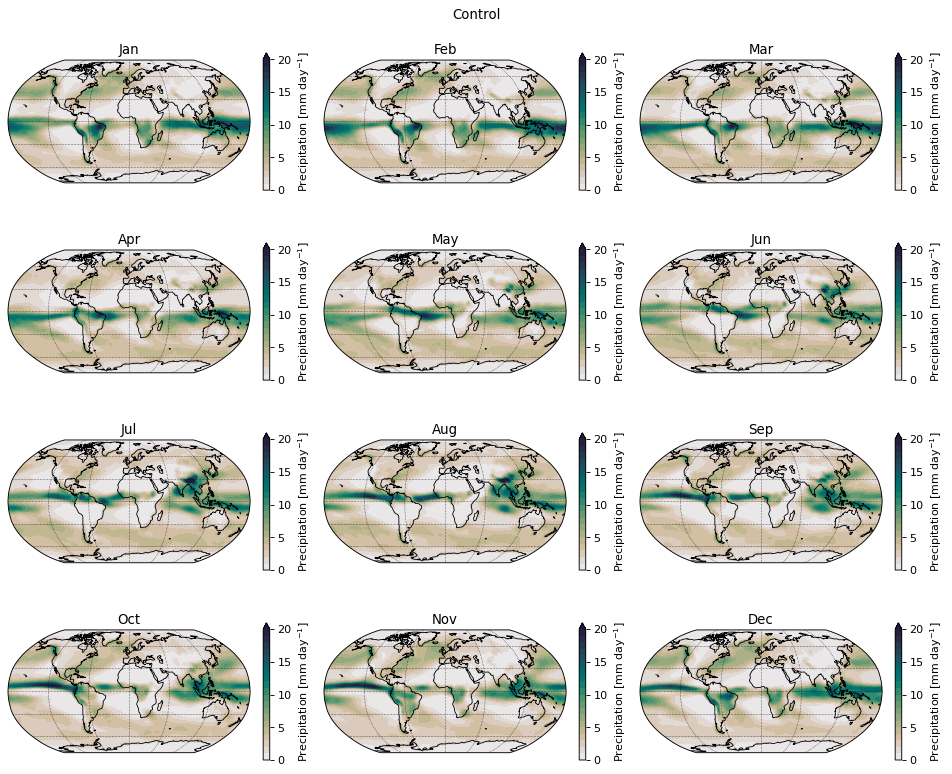

In [164]:
## Analysis
prec_ctl_clim = prec_ctl.groupby('time.month').mean(dim='time')

## Visualization
lon = prec_ctl.lon
mapproj = ccrs.Robinson()
cmap = cmo.rain
cflevels = np.arange(0,20.1,1)
cbticks = [0,5,10,15,20]
cblabel = 'Precipitation [mm day$^{-1}$]'
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig,axes = plt.subplots(4,3,figsize=(12,10),subplot_kw={'projection':mapproj})
ax = axes.ravel()

for i,a in enumerate(ax):
    cf_dif = cds.cyclic_contourf(a, prec_ctl_clim.isel(month=i),
                                 levels=cflevels, cmap=cmap, extend='max',
                                 transform=ccrs.PlateCarree())
    cb_dif = fig.colorbar(cf_dif, ax=a, fraction=0.025, label=cblabel)
    cb_dif.set_ticks(cbticks)
    a.set_title(months[i])
    a.coastlines(lw=0.75)
    cds.add_cartopy_gridlines(a, mapproj)

fig.suptitle('Control')
fig.tight_layout()

### Constant VPD only

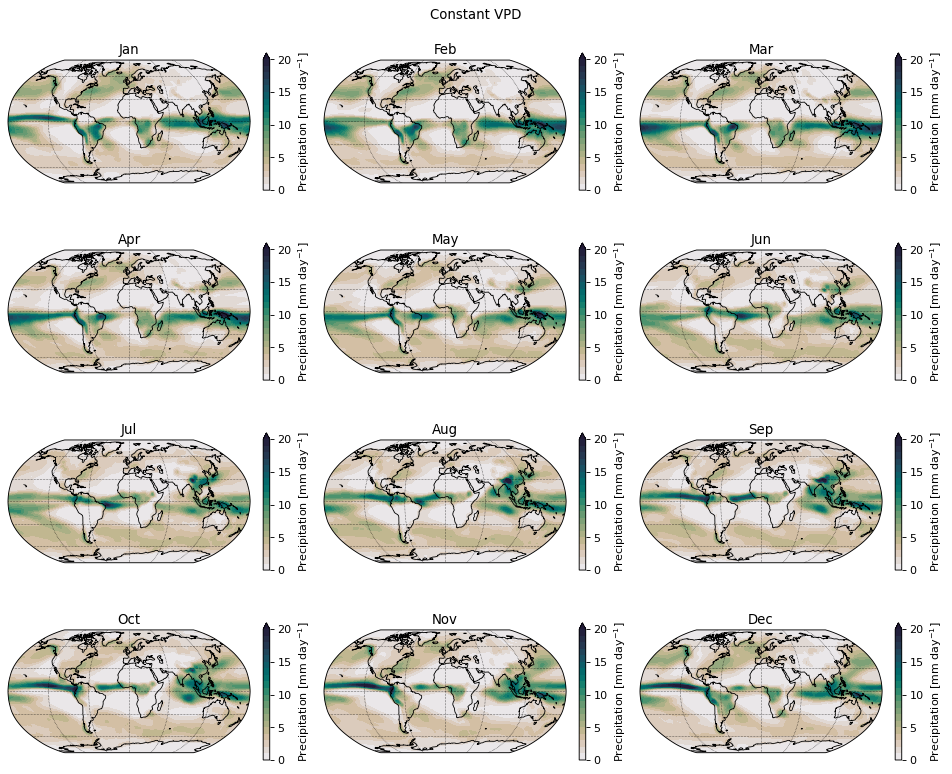

In [166]:
## Analysis
prec_vpd_clim = prec_vpd.groupby('time.month').mean(dim='time')

## Visualization
lon = prec_ctl.lon
mapproj = ccrs.Robinson()
cmap = cmo.rain
cflevels = np.arange(0,20.1,1)
cbticks = [0,5,10,15,20]
cblabel = 'Precipitation [mm day$^{-1}$]'
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig,axes = plt.subplots(4,3,figsize=(12,10),subplot_kw={'projection':mapproj})
ax = axes.ravel()

for i,a in enumerate(ax):
    cf_dif = cds.cyclic_contourf(a, prec_vpd_clim.isel(month=i),
                                 levels=cflevels, cmap=cmap, extend='max',
                                 transform=ccrs.PlateCarree())
    cb_dif = fig.colorbar(cf_dif, ax=a, fraction=0.025, label=cblabel)
    cb_dif.set_ticks(cbticks)
    a.set_title(months[i])
    a.coastlines(lw=0.75)
    cds.add_cartopy_gridlines(a, mapproj)

fig.suptitle('Constant VPD')
fig.tight_layout()

### Constant VPD $-$ Control

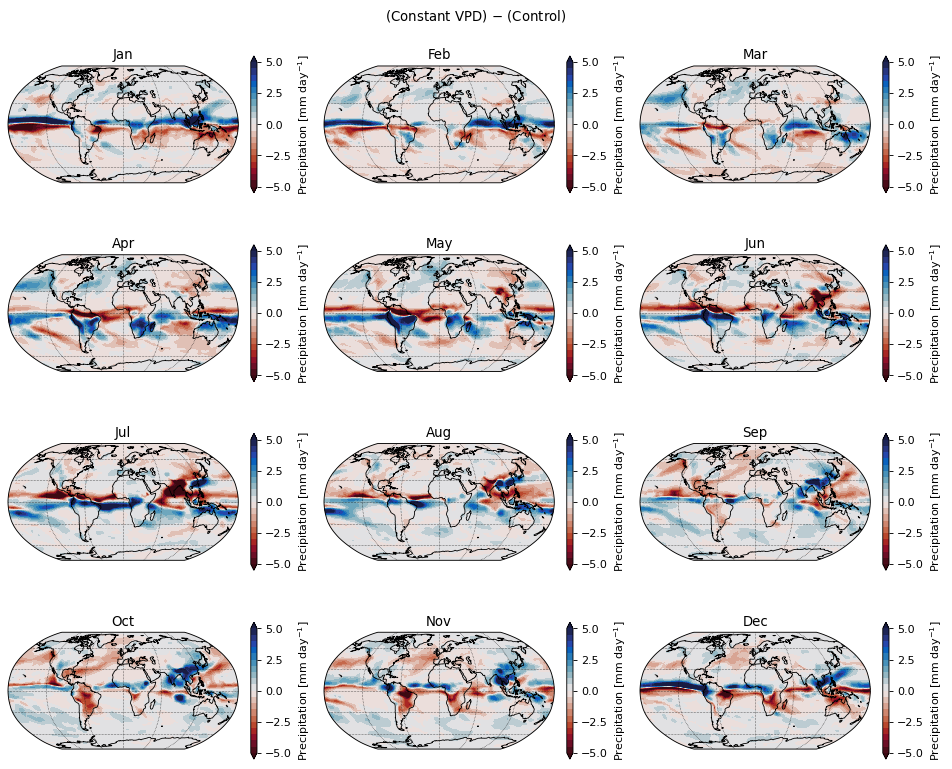

In [161]:
## Analysis
prec_ctl_clim = prec_ctl.groupby('time.month').mean(dim='time')
prec_vpd_clim = prec_vpd.groupby('time.month').mean(dim='time')

## Visualization
lon = prec_ctl.lon
mapproj = ccrs.Robinson()
cmap = cmo.balance_r
cflevels = np.arange(-5,5.1,0.5)
cbticks = [-5,-2.5,0,2.5,5]
cblabel = 'Precipitation [mm day$^{-1}$]'
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig,axes = plt.subplots(4,3,figsize=(12,10),subplot_kw={'projection':mapproj})
ax = axes.ravel()

for i,a in enumerate(ax):
    cf_dif = cds.cyclic_contourf(a, prec_vpd_clim.isel(month=i)-prec_ctl_clim.isel(month=i),
                                 levels=cflevels, cmap=cmap, extend='both',
                                 transform=ccrs.PlateCarree())
    cb_dif = fig.colorbar(cf_dif, ax=a, fraction=0.025, label=cblabel)
    cb_dif.set_ticks(cbticks)
    a.set_title(months[i])
    a.coastlines(lw=0.75)
    cds.add_cartopy_gridlines(a, mapproj)

fig.suptitle('(Constant VPD) $-$ (Control)')
fig.tight_layout()

## Global areal average

In [167]:
# Compute the global mean using cosine(lat) weighting
lat = prec_ctl.lat
coslat_weights = np.cos(lat * np.pi / 180)
prec_ctl_globmean = (prec_ctl.mean(dim='lon') * coslat_weights).sum(dim='lat') / coslat_weights.sum()
prec_vpd_globmean = (prec_vpd.mean(dim='lon') * coslat_weights).sum(dim='lat') / coslat_weights.sum()

# Compute climatology
prec_ctl_globclim = prec_ctl_globmean.groupby('time.month').mean()
prec_vpd_globclim = prec_vpd_globmean.groupby('time.month').mean()

# Compute anomalies from climatology
prec_ctl_globanom = prec_ctl_globmean.groupby('time.month') - prec_ctl_globclim
prec_vpd_globanom = prec_vpd_globmean.groupby('time.month') - prec_vpd_globclim

### Climatology timeseries

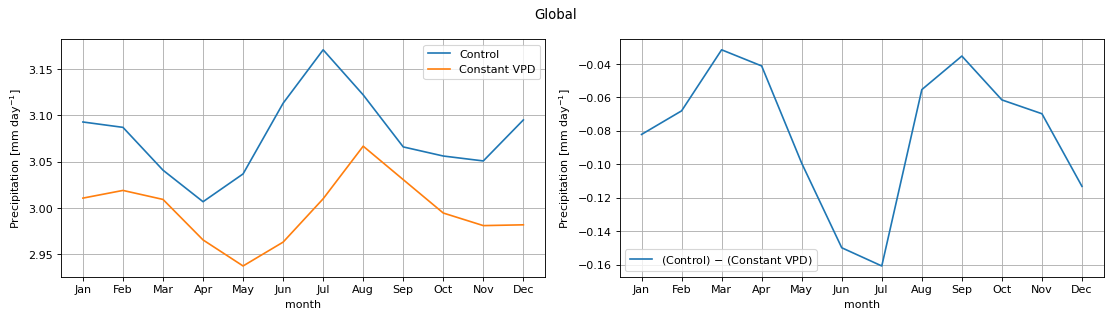

In [170]:
# Visualization
fig,ax = plt.subplots(1,2,figsize=(14,4))

prec_ctl_globclim.plot(ax=ax[0], label='Control')
prec_vpd_globclim.plot(ax=ax[0], label='Constant VPD')

(prec_vpd_globclim-prec_ctl_globclim).plot(ax=ax[1], label='(Control) $-$ (Constant VPD)')

for a in ax:
    a.set_xticks(np.arange(1,13))
    a.set_xticklabels(months)
    a.set_ylabel('Precipitation [mm day$^{-1}$]')
    a.legend()
    a.grid()
    
fig.suptitle('Global')
fig.tight_layout()

### Full timeseries of anomalies (deviation from climatology)

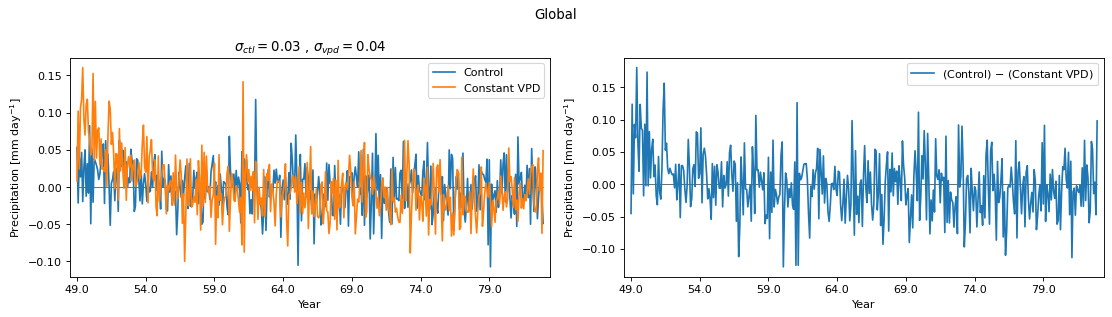

In [185]:
# Visualization
time = np.arange(49*12,83*12)

fig,ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(time, prec_ctl_globanom.values, label='Control')
ax[0].plot(time, prec_vpd_globanom.values, label='Constant VPD')
ax[0].legend()
ax[0].set_title('$\sigma_{ctl}=$'+str(prec_ctl_globanom.std().values.round(2))+' , '+
                '$\sigma_{vpd}=$'+str(prec_vpd_globanom.std().values.round(2)))

ax[1].plot(time, prec_vpd_globanom.values-prec_ctl_globanom.values, label='(Control) $-$ (Constant VPD)')
ax[1].legend()

for a in ax:
    a.plot([time[0],time[-1]], [0,0], linewidth=0.5, color='k', zorder=0)
    # a.set_ylim(-0.85,0.85)
    a.set_xlim(time[0]-6, time[-1]+6)
    a.set_xticks(time[::12*5])
    a.set_xticklabels(time[::12*5]/12)
    a.set_xlabel('Year')
    a.set_ylabel('Precipitation [mm day$^{-1}$]')
    
fig.suptitle('Global')
fig.tight_layout()

## Land areal average

In [172]:
# Compute the global mean using cosine(lat) weighting
lat = prec_ctl.lat
coslat_weights = np.cos(lat * np.pi / 180)
prec_ctl_landmean = (prec_ctl.where(landmask).mean(dim='lon') * coslat_weights).sum(dim='lat') / coslat_weights.sum()
prec_vpd_landmean = (prec_vpd.where(landmask).mean(dim='lon') * coslat_weights).sum(dim='lat') / coslat_weights.sum()

# Compute climatology
prec_ctl_landclim = prec_ctl_landmean.groupby('time.month').mean()
prec_vpd_landclim = prec_vpd_landmean.groupby('time.month').mean()

# Compute anomalies from climatology
prec_ctl_landanom = prec_ctl_landmean.groupby('time.month') - prec_ctl_landclim
prec_vpd_landanom = prec_vpd_landmean.groupby('time.month') - prec_vpd_landclim

### Climatology timeseries

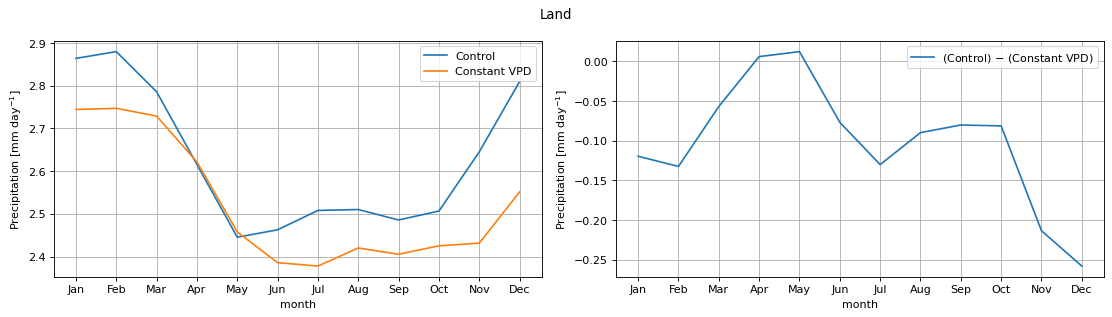

In [174]:
# Visualization
fig,ax = plt.subplots(1,2,figsize=(14,4))

prec_ctl_landclim.plot(ax=ax[0], label='Control')
prec_vpd_landclim.plot(ax=ax[0], label='Constant VPD')

(prec_vpd_landclim-prec_ctl_landclim).plot(ax=ax[1], label='(Control) $-$ (Constant VPD)')

for a in ax:
    a.set_xticks(np.arange(1,13))
    a.set_xticklabels(months)
    a.set_ylabel('Precipitation [mm day$^{-1}$]')
    a.legend()
    a.grid()
    
fig.suptitle('Land')
fig.tight_layout()

### Full timeseries of anomalies (deviation from climatology)

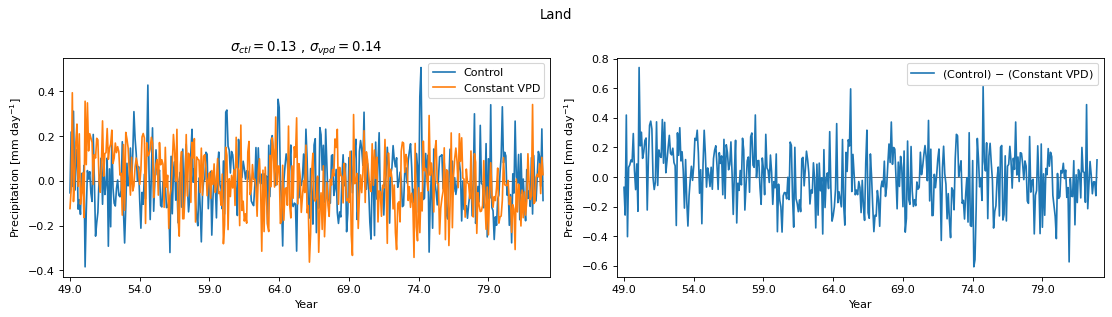

In [186]:
# Visualization
time = np.arange(49*12,83*12)

fig,ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(time, prec_ctl_landanom.values, label='Control')
ax[0].plot(time, prec_vpd_landanom.values, label='Constant VPD')
ax[0].set_title('$\sigma_{ctl}=$'+str(prec_ctl_landanom.std().values.round(2))+' , '+
                '$\sigma_{vpd}=$'+str(prec_vpd_landanom.std().values.round(2)))
ax[0].legend()

ax[1].plot(time, prec_vpd_landanom.values-prec_ctl_landanom.values, label='(Control) $-$ (Constant VPD)')
ax[1].legend()

for a in ax:
    a.plot([time[0],time[-1]], [0,0], linewidth=0.5, color='k', zorder=0)
    # a.set_ylim(-1.5,1.5)
    a.set_xlim(time[0]-6, time[-1]+6)
    a.set_xticks(time[::12*5])
    a.set_xticklabels(time[::12*5]/12)
    a.set_xlabel('Year')
    a.set_ylabel('Precipitation [mm day$^{-1}$]')
    
fig.suptitle('Land')
fig.tight_layout()